<a href="https://colab.research.google.com/github/vijjus/CV/blob/master/Compression_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!echo '3FDsALdx4sLyMedGxO5h:RsdZX1E2jRryINc6Vb5HGpL1FY84lNBXbTNSU8Ln' > ~/.passwd-s3fs
!cat ~/.passwd-s3fs
!chmod 600 ~/.passwd-s3fs
!mkdir /s3
!apt install s3fs
!s3fs w251-final-project /s3 -o passwd_file=~/.passwd-s3fs,url=https://s3.us.cloud-object-storage.appdomain.cloud

3FDsALdx4sLyMedGxO5h:RsdZX1E2jRryINc6Vb5HGpL1FY84lNBXbTNSU8Ln
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  s3fs
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 200 kB of archives.
After this operation, 557 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 s3fs amd64 1.82-1 [200 kB]
Fetched 200 kB in 0s (1,238 kB/s)
Selecting previously unselected package s3fs.
(Reading database ... 144579 files and directories currently installed.)
Preparing to unpack .../archives/s3fs_1.82-1_amd64.deb ...
Unpacking s3fs (1.82-1) ...
Setting up s3fs (1.82-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [2]:
import os
import torch
from torch.autograd import Variable
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib
import urllib.request
import cv2
from google.colab.patches import cv2_imshow
import re
import time
import copy
import os
import random
from PIL import Image
import json
import albumentations
from __future__ import print_function, division
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
import numpy.random as rand

In [18]:
!pip install facenet_pytorch

     |████████████████████████████████| 1.9MB 7.6MB/s 


In [19]:
from facenet_pytorch import MTCNN

In [27]:
fcmodel = MTCNN(image_size=224, margin=20, thresholds=[0.8,0.9,0.9], device=device)

In [4]:
path = "/s3/FF/original_sequences/youtube/"
compression_levels = ["raw", "c23", "c40"]


In [33]:
path = "/s3/FF/original_sequences/youtube/c23/videos"
video_list = os.listdir(path)

In [34]:
def mtcnn_scan(fcmodel, vid_path, num_images=1):
    """
    Use the passed in MTCNN face detector to look for up to num_images
    number of faces, and crop and return a list of cropped faces. The
    images are returned as a numpy array.
    """
    cap = cv2.VideoCapture(vid_path)
    
    count = 0    
    crops = []
    
    while (True):
        if count >= num_images:
            break
        ret, img = cap.read()   
        if not ret:
            break

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img = Image.fromarray(np.uint8(img)).convert('RGB')
        
        img = fcmodel(img)

        crops.append(img.permute(1,2,0).cpu().numpy())
        
        count += 1
    
    cap.release()

    return crops

In [78]:
def get_all_levels(path_type, vid_name):
  frames = []
  for c in compression_levels:
    vid_path = os.path.join(path_type,c,'videos',vid_name)
    print(f"Getting frames for video {vid_name} from {vid_path}")
    f = mtcnn_scan(fcmodel, vid_path)
    if len(f) != 0:
      frames.append(*f)
  return frames

In [71]:
def show_frame_lattice(frames, deblue=False, per_row=3, img_height=5, image_width=5):
    """
    Takes as an input a list of face crops, and displays it in a
    4 x N grid, where N typically is the number of videos. The basic
    idea is to be able to see images side by side for comparison
    purposes. Input images can be either in numpy (H,W,C) or PyTorch
    (C,H,W) format.
    """
    height = len(frames)//per_row * img_height
    width = per_row * image_width
    fig=plt.figure(figsize=(width, height))
    columns = per_row
    count = len(frames)
    rows = int(np.ceil(count/columns))
    for i in range(0, count):
        img = frames[i]
        if isinstance(img, np.ndarray) or isinstance(img, torch.Tensor):
            if img.max() != 255 and (img.max() > 1.0 or img.min() < 0.0):
                img = img + max(img.max(), abs(img.min()))
                img = img/img.max()
        fig.add_subplot(rows, columns, i+1)
        if isinstance(img, torch.Tensor):
            img = img.permute(1,2,0).numpy()
        if deblue:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    fig.tight_layout()
    plt.show()

Getting frames for video 004.mp4 from /s3/FF/original_sequences/youtube/raw/videos/004.mp4
Getting frames for video 004.mp4 from /s3/FF/original_sequences/youtube/c23/videos/004.mp4
Getting frames for video 004.mp4 from /s3/FF/original_sequences/youtube/c40/videos/004.mp4


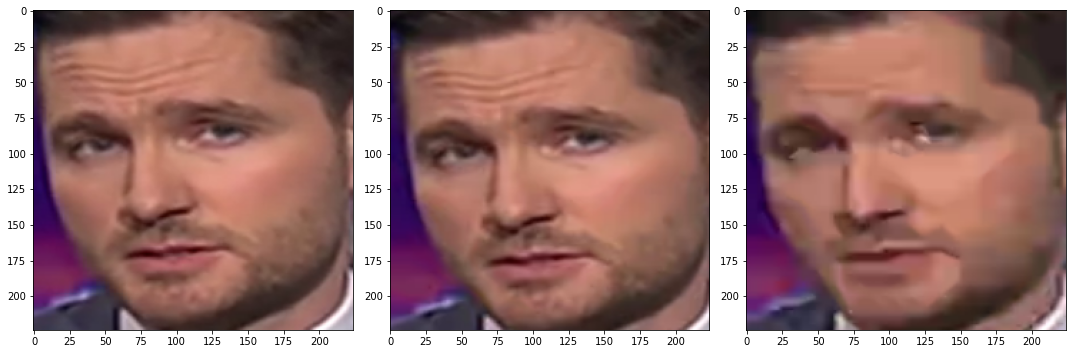

In [94]:
path_orig = "/s3/FF/original_sequences/youtube/"
video_list = os.listdir(os.path.join(path_orig, 'raw/videos'))
frames = []
for v in video_list[:1]:
  fr = get_all_levels(path_orig, v)
  for f in fr:
    frames.append(f)
show_frame_lattice(frames)

Getting frames for video 004_982.mp4 from /s3/FF/manipulated_sequences/FaceSwap/raw/videos/004_982.mp4
Getting frames for video 004_982.mp4 from /s3/FF/manipulated_sequences/FaceSwap/c23/videos/004_982.mp4
Getting frames for video 004_982.mp4 from /s3/FF/manipulated_sequences/FaceSwap/c40/videos/004_982.mp4


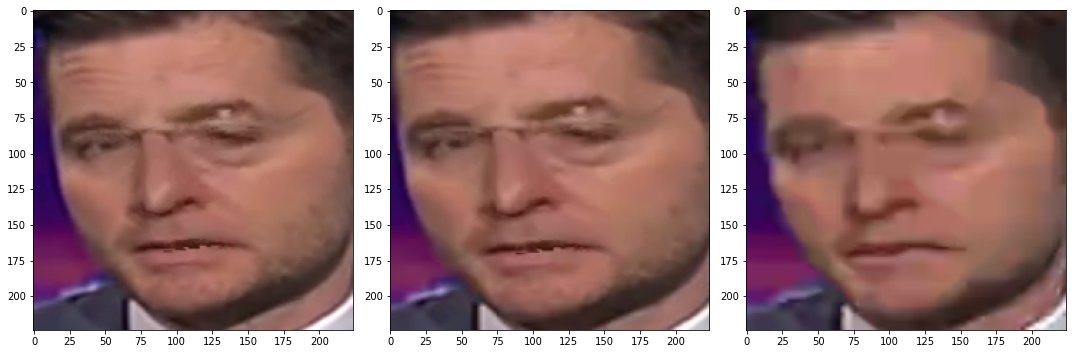

In [96]:
path_face_swap = '/s3/FF/manipulated_sequences/FaceSwap/'
video_list = os.listdir(os.path.join(path_face_swap, 'raw/videos/'))
frames_face_swap = []
for v in video_list[:1]:
  fr = get_all_levels(path_face_swap, v)
  for f in fr:
    frames_face_swap.append(f)
show_frame_lattice(frames_face_swap)

Getting frames for video 004_982.mp4 from /s3/FF/manipulated_sequences/NeuralTextures/raw/videos/004_982.mp4
Getting frames for video 004_982.mp4 from /s3/FF/manipulated_sequences/NeuralTextures/c23/videos/004_982.mp4
Getting frames for video 004_982.mp4 from /s3/FF/manipulated_sequences/NeuralTextures/c40/videos/004_982.mp4


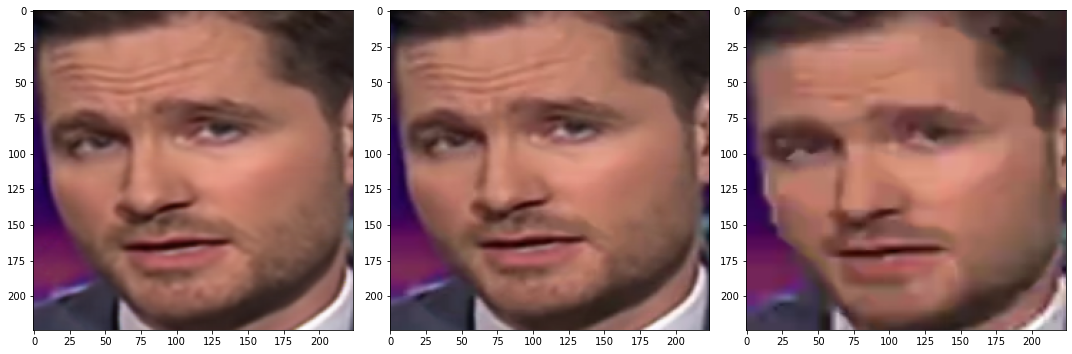

In [92]:
path_nt = '/s3/FF/manipulated_sequences/NeuralTextures'
video_list = os.listdir(os.path.join(path_nt, 'raw/videos'))
frames_nt = []
for v in video_list[:1]:
  fr = get_all_levels(path_nt, v)
  for f in fr:
    frames_nt.append(f)
show_frame_lattice(frames_nt)